Name: Zixi Wang

Github Username: lacunaxu

USC ID: 2854187591

In [27]:
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut

1. Tree-Based Methods

(a) Download the APS Failure dataset from this link. The dataset contains a training set with 60,000 rows, including 1,000 positive class instances, and 171 columns (one being the class column). All attributes are numeric.

(b) Data Preparation

The dataset has missing values. When the number of missing data points is substantial, discarding them is not advisable. i. Research data imputation techniques and choose at least one method to apply in subsequent steps. ii. Calculate the coefficient of variation CV = s / m for each of the 170 features, where s is the sample standard deviation and m is the sample mean. iii. Plot a correlation matrix for the features using pandas or another tool. iv. Select the floor(sqrt(170)) features with the highest CV and create scatter plots and box plots for them, similar to those on page 129 of ISLR. Draw conclusions about their significance from these plots, if possible. v. Determine the number of positive and negative instances in the dataset. Is it imbalanced?
(c) Train a random forest to classify the dataset without compensating for class imbalance. Report the confusion matrix, ROC, AUC, and misclassification rate for both the training and test sets (using tools like the pROC package). Calculate the Out of Bag (OOB) error estimate for the random forest and compare it to the test error.

(d) Research how class imbalance is addressed in random forests. Train a random forest with class imbalance compensation and repeat step 1(c). Compare these results with those of step 1(c).

(e) XGBoost and Model Trees In univariate trees, only one input dimension is used at each split. In multivariate or model trees, all input dimensions can be considered at decision nodes, making them more general. Univariate classification trees use majority polling for node splitting, while model trees use linear models dependent on all variables to determine splits (e.g., sum(beta_j * X_j) > s instead of X_j > s). Regression trees use linear regression instead of an average for values at nodes.

Logistic regression can be used at nodes. Due to the large number of variables, L1-penalized logistic regression is suitable for this problem. Use XGBoost to fit the model tree, determining the regularization term alpha via cross-validation. Train the model without class imbalance compensation. Use one of 5-fold, 10-fold, or leave-one-out cross-validation to estimate the error and compare it with the test error. Report the confusion matrix, ROC, and AUC for training and test sets.

(f) Pre-process the data using SMOTE to compensate for class imbalance. Train an XGBoost model with L1-penalized logistic regression at each node using the pre-processed data and repeat step 1(e). Ensure correct cross-validation procedures are followed. Compare results between the uncompensated and SMOTE cases.

2. ISLR 6.6.3
3. ISLR 6.6.5
4. ISLR 8.4.5
5. ISLR 9.7.3
6. Extra Practice

In [28]:
#(a)
overall_path = os.getcwd()
new_path = os.path.dirname(overall_path)
training_path = os.path.join(new_path, 'data', 'aps_failure', 'aps_failure_training_set.csv')
test_path = os.path.join(new_path, 'data', 'aps_failure', 'aps_failure_training_set.csv')

def read_file(path):
    data_list = []
    with open(path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for i, row in enumerate(reader, 1):
            if len(row) == 171:
                data_list.append(row)
        return data_list

training_data_list = read_file(training_path)    
test_data_list = read_file(test_path)    

#(bi)
training_data = pd.DataFrame(training_data_list[1:], columns=training_data_list[0])
test_data = pd.DataFrame(test_data_list[1:], columns=test_data_list[0])

def clean_and_convert_data(data):
    data.replace('na', np.nan, inplace=True)
    numeric_columns = data.columns.difference(['class'])
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')
    data['class'] = data['class'].astype('string')
    categorical_columns = data.select_dtypes(include='string').columns
    numeric_data = data.drop(columns=categorical_columns)
    numeric_data = numeric_data.astype(float)
    numeric_data.fillna(numeric_data.mean(numeric_only=True), inplace=True)
    data[numeric_data.columns] = numeric_data
    return data

training_data = clean_and_convert_data(training_data)
test_data = clean_and_convert_data(test_data)

print(training_data.dtypes)
print(test_data.dtypes)
print(training_data.head())
print(test_data.head())

class      string
aa_000    float64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object
class      string
aa_000    float64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object
  class   aa_000    ab_000        ac_000         ad_000  ae_000  af_000  \
0   neg  76698.0  0.713189  2.130706e+09     280.000000     0.0     0.0   
1   neg  33058.0  0.713189  0.000000e+00  190620.639314     0.0     0.0   
2   neg  41040.0  0.713189  2.280000e+02     100.000000     0.0     0.0   
3   neg     12.0  0.000000  7.000000e+01      66.000000     0.0    10.0   
4   neg  60874.0  0.713189  1.368000e+03     458.000000     0.0     0.0   

   ag_000  ag_001  ag_002  ...     ee_002    ee_003    ee_004    ee_005  \
0     0.0     0.0     0.

In [29]:
#(bii)
cv = training_data.std() / training_data.mean()
cv

C:\Users\wumin\AppData\Local\Temp\ipykernel_23720\2602666641.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cv = training_data.std() / training_data.mean()
C:\Users\wumin\AppData\Local\Temp\ipykernel_23720\2602666641.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cv = training_data.std() / training_data.mean()


aa_000      2.450938
ab_000      2.328400
ac_000      2.169767
ad_000    183.847620
ae_000     23.190937
             ...    
ee_007      4.962483
ee_008      3.222010
ee_009      5.626979
ef_000     47.124953
eg_000     40.553250
Length: 170, dtype: float64

In [30]:
#(biii)

correlation_matrix = training_data.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

C:\Users\wumin\AppData\Local\Temp\ipykernel_23720\2350869297.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = training_data.corr()
C:\Users\wumin\anaconda3\lib\site-packages\pandas\io\formats\style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\wumin\anaconda3\lib\site-packages\pandas\io\formats\style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [31]:
print(training_data['cd_000'].isna().sum())
print(training_data['cd_000'].unique())    
#cd_000 is nan is because When all values in a column are the same (no variability), its standard deviation is 0. 
#and cd+000 only has one value
#Calculating the correlation coefficient requires dividing by the standard deviation, so columns with a standard 
#deviation of 0 cannot be correlated so it displayed as NaN.

0
[1209600.]


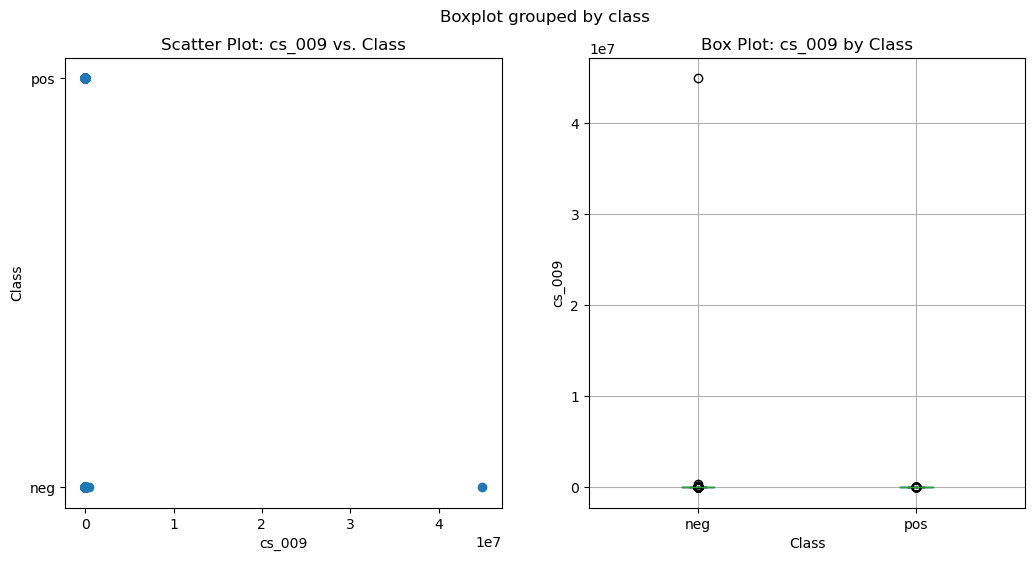

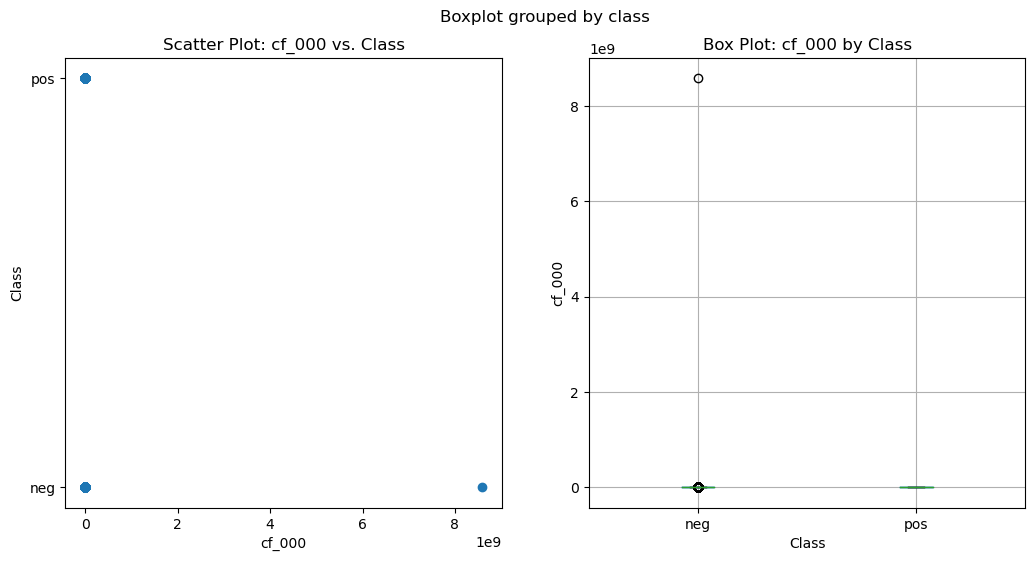

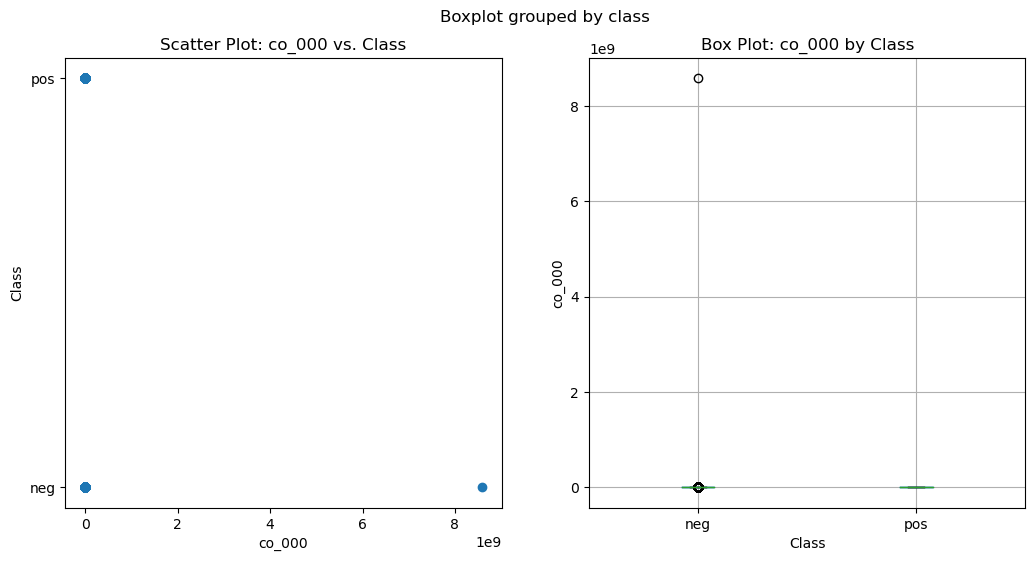

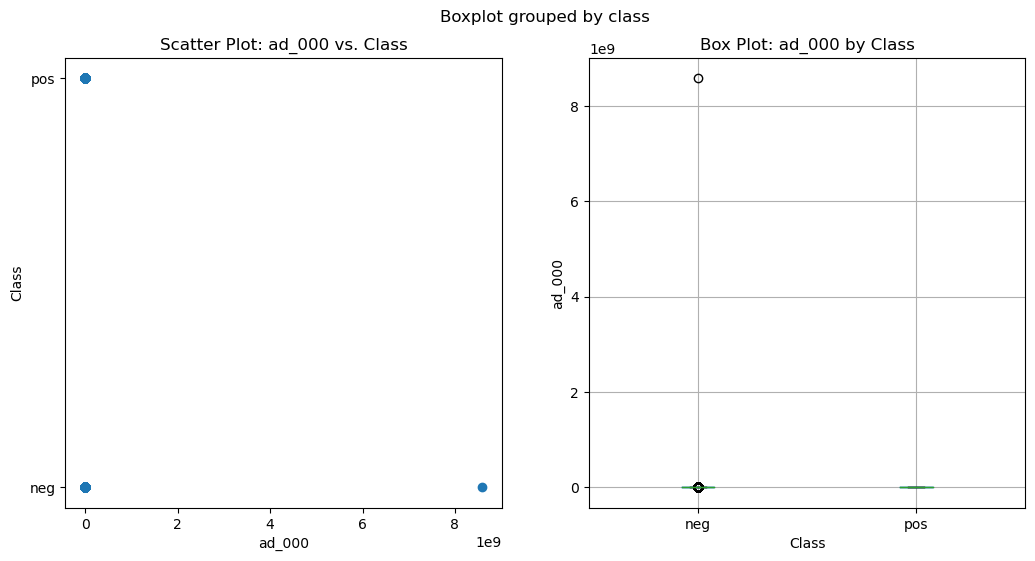

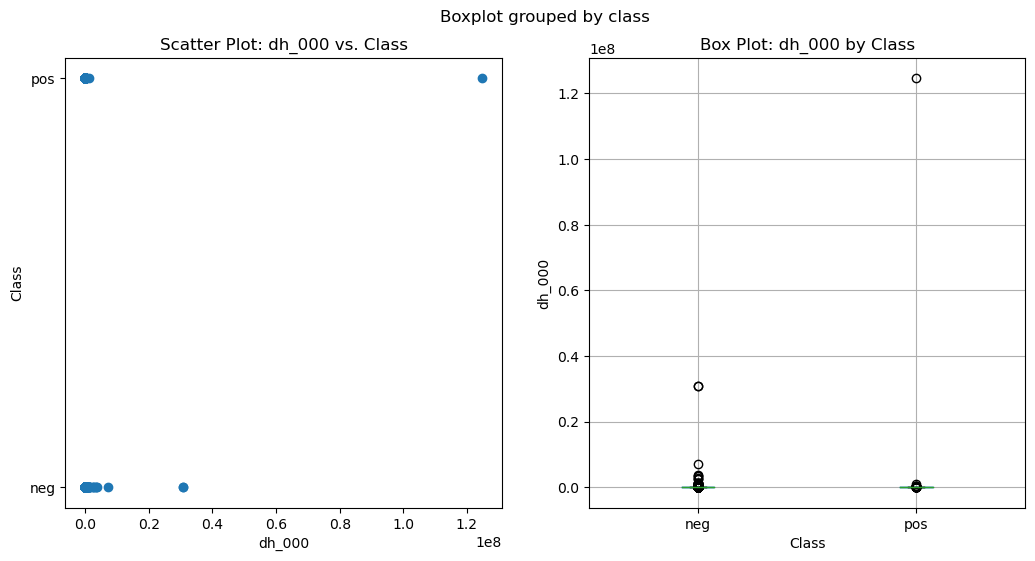

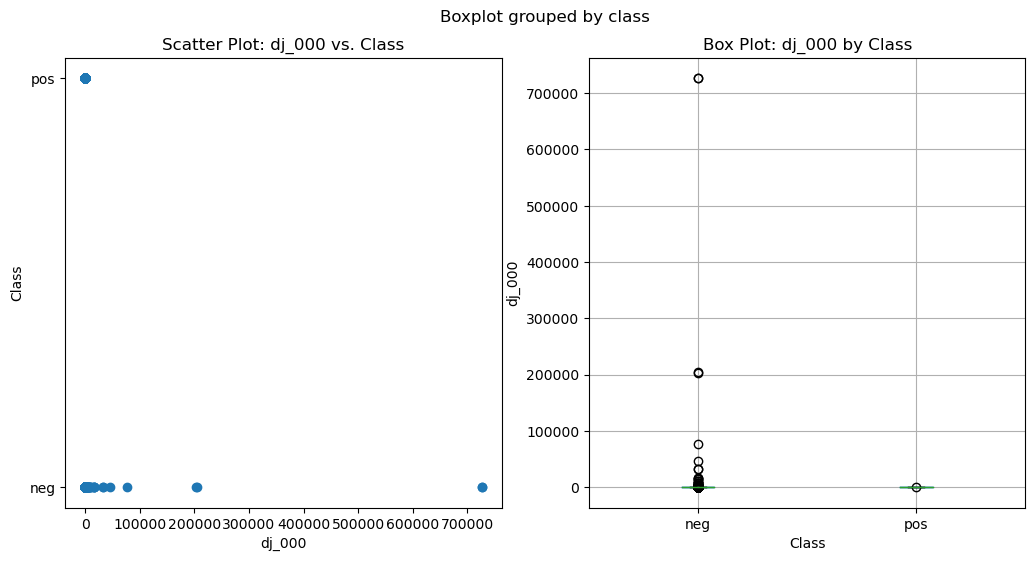

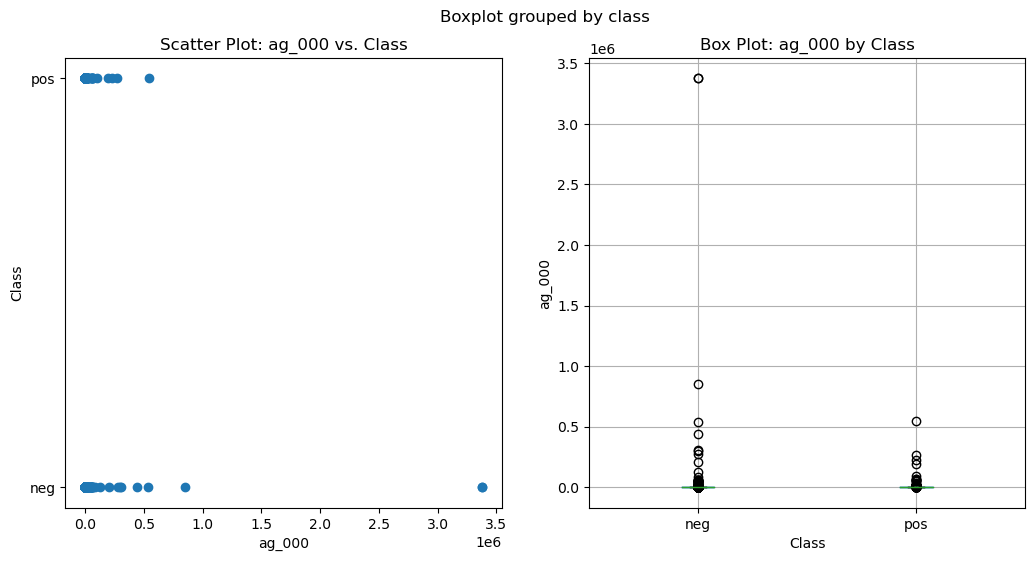

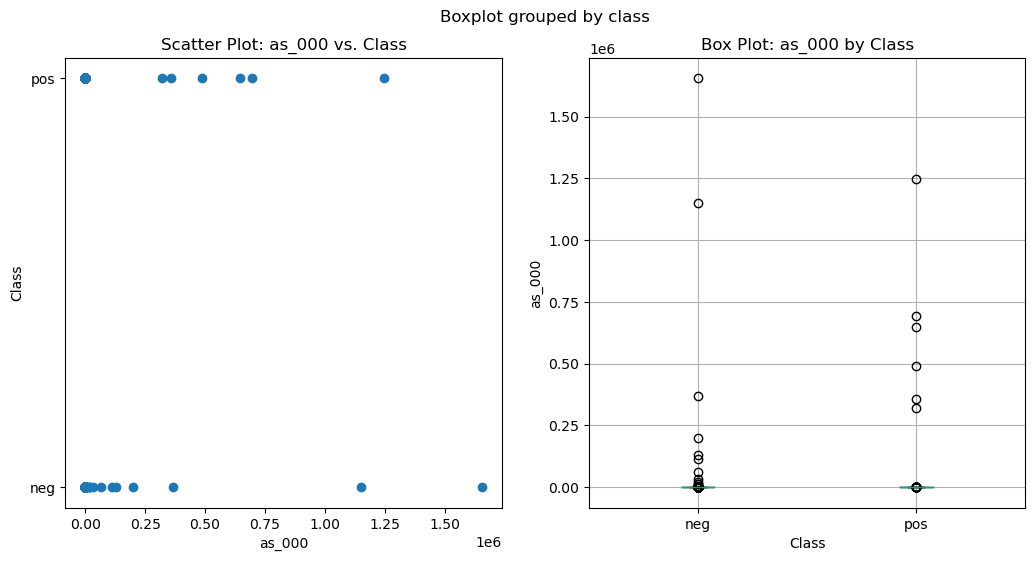

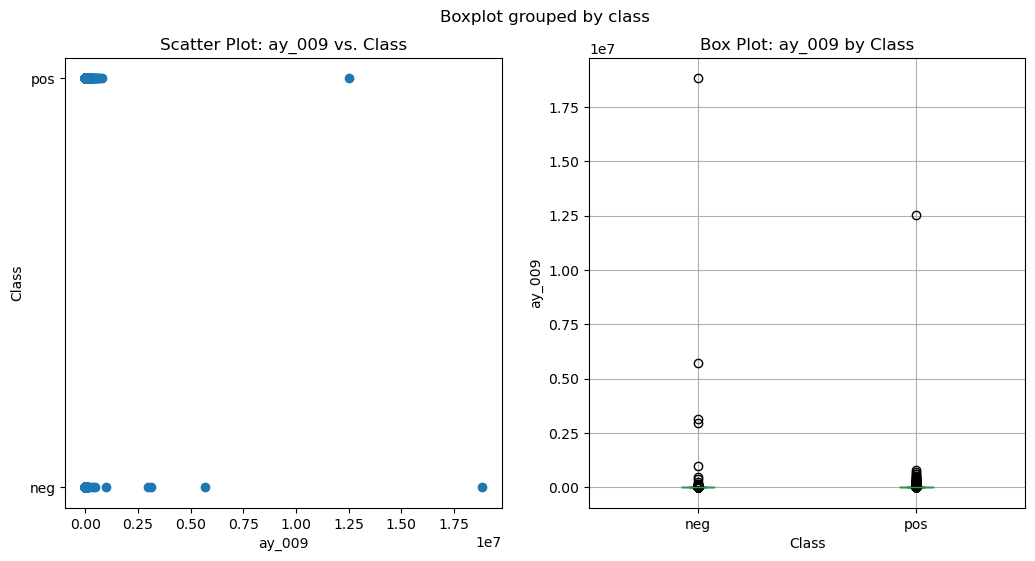

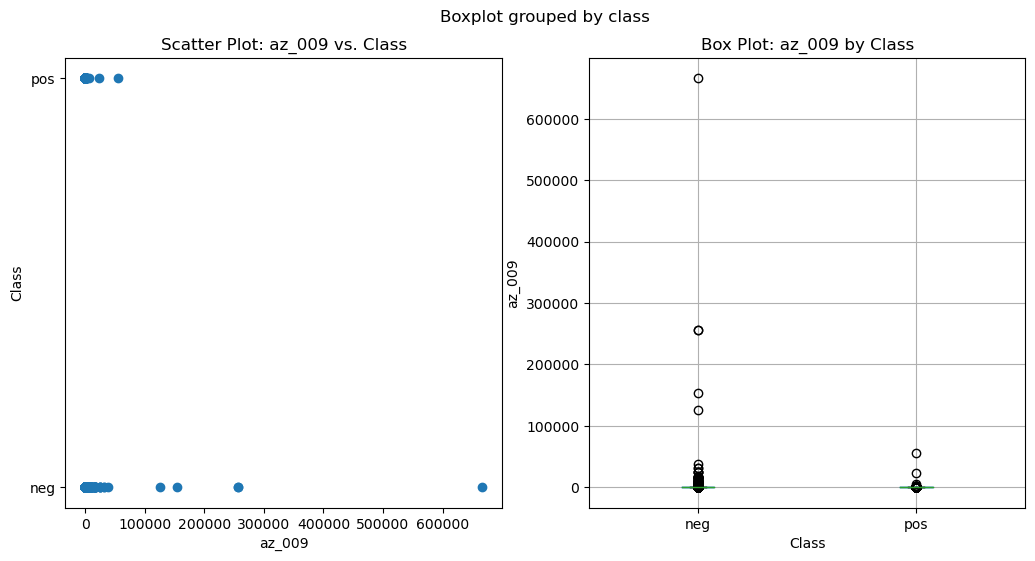

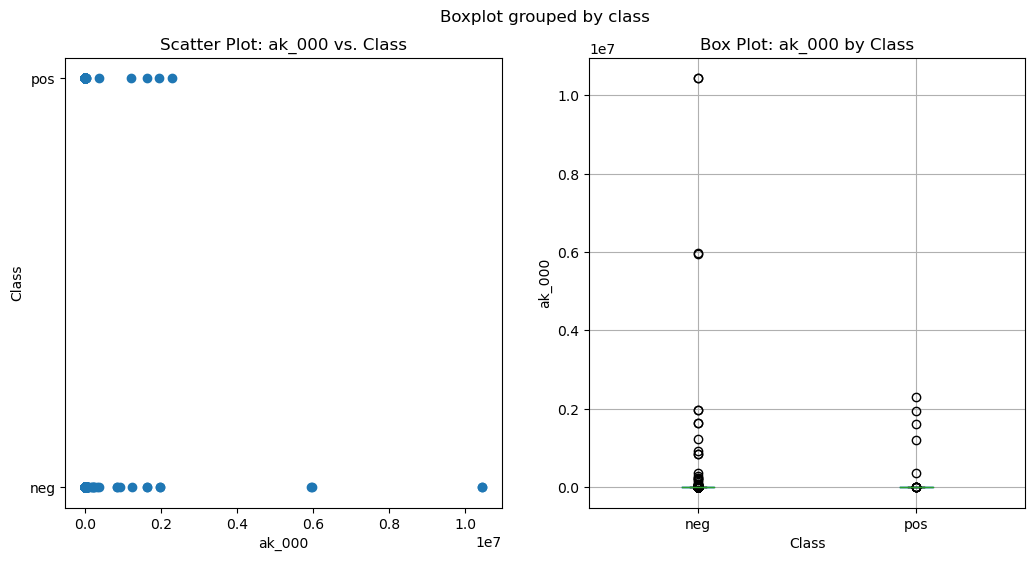

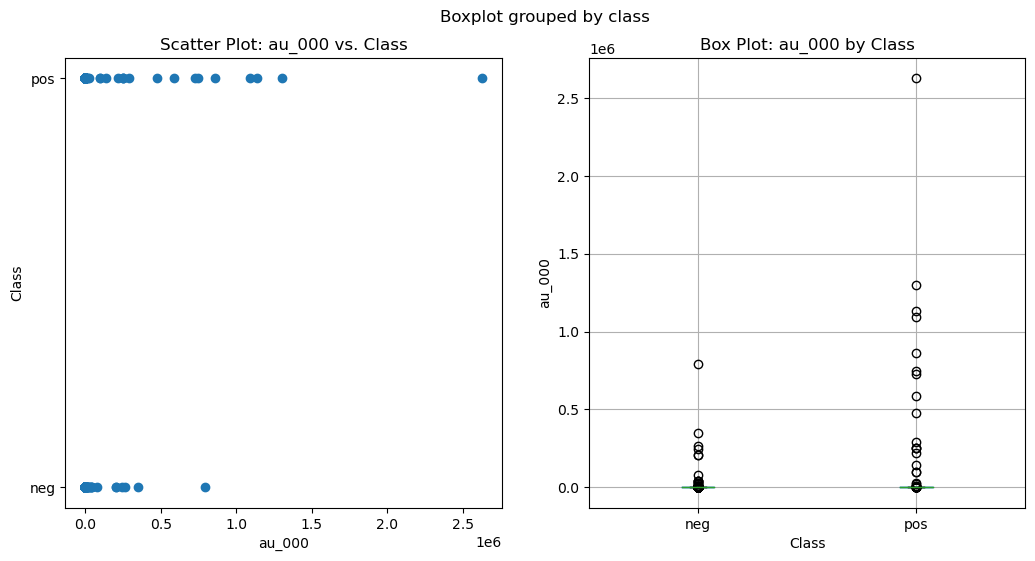

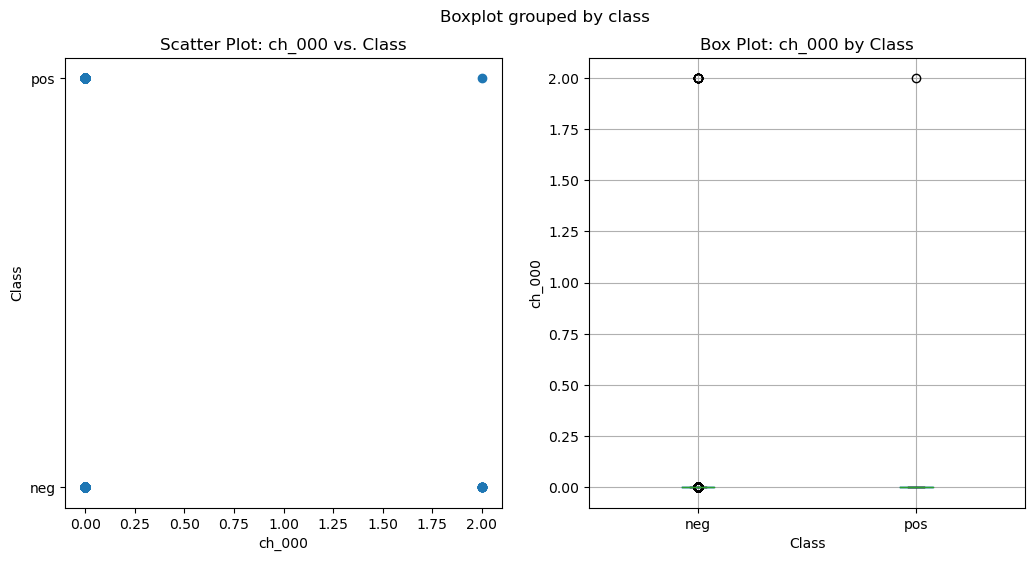

In [32]:
#(b)iv
top_training_features = int(np.sqrt(170))
top_features = cv.sort_values(ascending=False).head(top_training_features).index

import matplotlib.pyplot as plt

for feature in top_features:
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    axes[0].scatter(training_data[feature], training_data['class'])
    axes[0].set_title(f"Scatter Plot: {feature} vs. Class")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Class')
    
    training_data.boxplot(column=feature, by='class', ax=axes[1])
    axes[1].set_title(f"Box Plot: {feature} by Class")
    axes[1].set_ylabel(feature)
    axes[1].set_xlabel('Class')
    
    plt.show()

In the scatter plot, the Class variable is displayed as discrete values ​​(pos and neg). Some plots have significant separation: for example, the feature values ​​such as co_000, ad_000 show completely different ranges between the pos and neg categories, and this feature may have a greater ability to distinguish between the categories.
Some plots also have partial overlaps: for example, as_000, cs_009, ag_000, some feature values ​​have significant overlaps in pos and neg. This feature may have a smaller ability to distinguish between the categories. The box plot shows the distribution of each feature under different categories, including median, q1, q3, median, and outliers. Some features of the plots have completely different medians and ranges in the two categories (such as co_000), such as co_000, ad_000, dj_000, neg, and the feature value range is much higher than pos. This shows that this feature may be very important for distinguishing between neg and pos categories.
There are also some features whose distribution in the two categories is not much different, such as the median and distribution range of some as_000, ak_000, dh_000 are almost the same in the two categories, which may have little impact in the classification.

In [33]:
#(b)v
class_counts = training_data['class'].value_counts()
print("Class Distribution:")
print(class_counts)

positive_count = class_counts.get('pos', 0)
negative_count = class_counts.get('neg', 0)

imbalance_ratio = 0
if negative_count > 0:
    imbalance_ratio = positive_count / negative_count
    
if imbalance_ratio < 0.5 or imbalance_ratio > 2:
    print("The dataset is imbalanced.")
else:
    print("The dataset is balanced.")

Class Distribution:
neg    59000
pos     1000
Name: class, dtype: Int64
The dataset is imbalanced.


In [34]:
#(c)
X_train = training_data.drop(columns=['class'])
y_train = training_data['class'].map({'pos': 1, 'neg': 0})
X_test = test_data.drop(columns=['class'])
y_test = test_data['class'].map({'pos': 1, 'neg': 0})

print(y_train.isna().sum()) 
print(y_test.isna().sum()) 
print(training_data['class'].unique())
print(test_data['class'].unique())

0
0
<StringArray>
['neg', 'pos']
Length: 2, dtype: string
<StringArray>
['neg', 'pos']
Length: 2, dtype: string


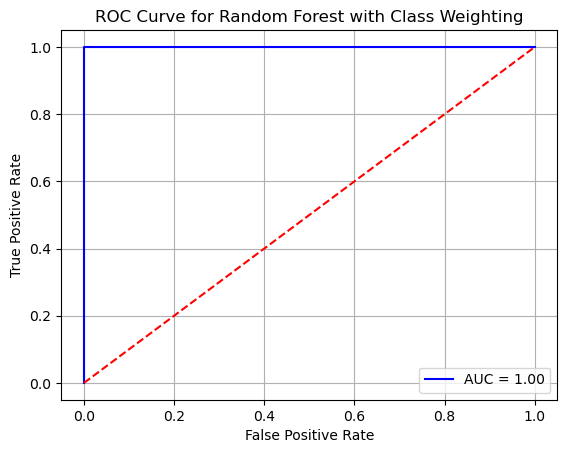

Training Confusion Matrix is:
[[59000     0]
 [    1   999]]

Testing Confusion Matrix is:
[[59000     0]
 [    1   999]]

Train Misclassification Rate is: 0.0000
Test Misclassification Rate is: 0.0000

Train AUC is: 1.0000
Test AUC is: 1.0000


In [36]:
def random_forest(X_train, y_train, X_test, y_test, class_weight=None, model_label="Random Forest"):

    rf = RandomForestClassifier(oob_score=True, class_weight=class_weight, random_state=42)
    rf.fit(X_train, y_train)

    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    y_train_prob = rf.predict_proba(X_train)[:, 1]
    y_test_prob = rf.predict_proba(X_test)[:, 1]

    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)

    fpr, tpr, _ = roc_curve(y_test, y_test_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {test_auc:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_label}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    train_misclassification = 1 - accuracy_score(y_train, y_train_pred)
    test_misclassification = 1 - accuracy_score(y_test, y_test_pred)

    oob_error = 1 - rf.oob_score_ if class_weight is not None else None

    print(f"Training Confusion Matrix is:\n{train_conf_matrix}")
    print(f"\nTesting Confusion Matrix is:\n{test_conf_matrix}")
    print(f"\nTrain Misclassification Rate is: {train_misclassification:.4f}")
    print(f"Test Misclassification Rate is: {test_misclassification:.4f}")
    if oob_error is not None:
        print(f"OOB Error Estimate is: {oob_error:.4f}")
    print(f"\nTrain AUC is: {train_auc:.4f}")
    print(f"Test AUC is: {test_auc:.4f}")


random_forest(X_train, y_train, X_test, y_test, model_label="Random Forest with Class Weighting")


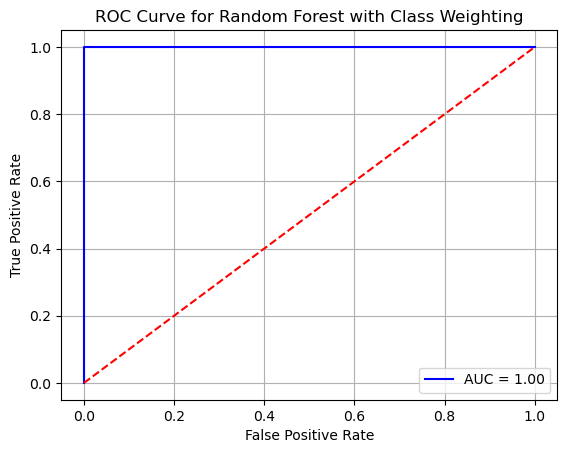

Training Confusion Matrix is:
[[59000     0]
 [    1   999]]

Testing Confusion Matrix is:
[[59000     0]
 [    1   999]]

Train Misclassification Rate is: 0.0000
Test Misclassification Rate is: 0.0000
OOB Error Estimate is: 0.0077

Train AUC is: 1.0000
Test AUC is: 1.0000


In [37]:
#(d)
random_forest(X_train, y_train, X_test, y_test, class_weight="balanced", model_label="Random Forest with Class Weighting")
#My result doesn't have any difference, they all only have one Misclassification

=== 5-Fold Cross Validation Without SMOTE ===
Best parameters (5-fold, No Compensation): {'alpha': 5}

Confusion Matrix (Training):
[[59000     0]
 [   38   962]]

Confusion Matrix (Testing):
[[59000     0]
 [   38   962]]
Train AUC: 0.9998
Test AUC: 0.9998
Train Misclassification Rate: 0.0006
Test Misclassification Rate: 0.0006


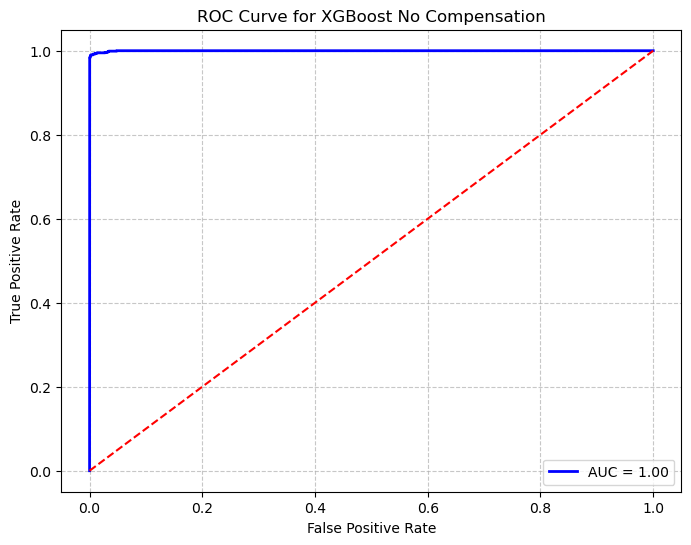

=== 10-fold Cross Validation Without SMOTE ===
Best parameters (10-fold, No Compensation): {'alpha': 10}

Confusion Matrix (Training):
[[58986    14]
 [  113   887]]

Confusion Matrix (Testing):
[[58986    14]
 [  113   887]]
Train AUC: 0.9983
Test AUC: 0.9983
Train Misclassification Rate: 0.0021
Test Misclassification Rate: 0.0021


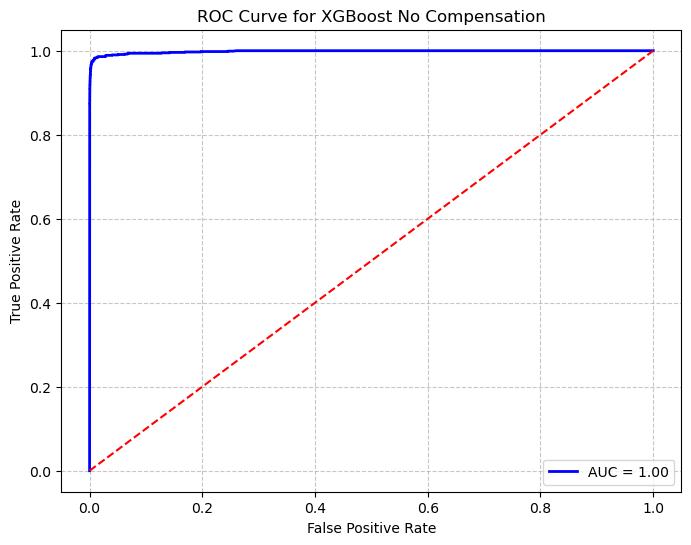

=== 5-Fold Cross Validation Without SMOTE ===
Best parameters (5-fold, with SMOTE): {'alpha': 1}

Confusion Matrix (Training):
[[59000     0]
 [    2 58998]]

Confusion Matrix (Testing):
[[59000     0]
 [    2   998]]
Train AUC: 1.0000
Test AUC: 1.0000
Train Misclassification Rate: 0.0000
Test Misclassification Rate: 0.0000


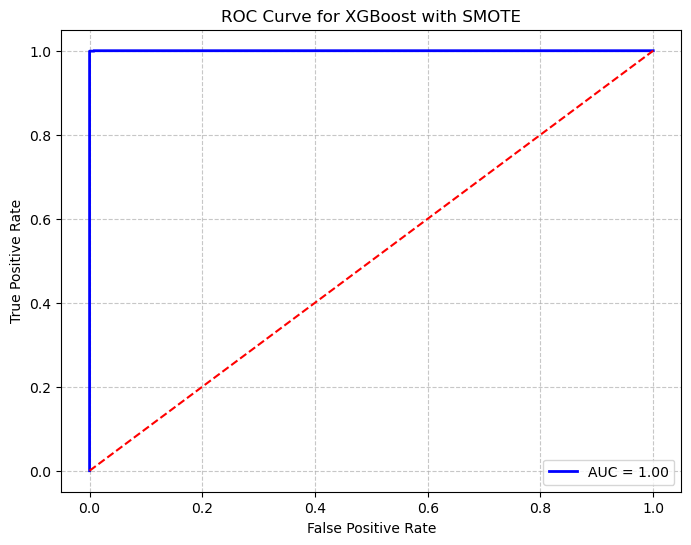

=== 10-fold Cross Validation Without SMOTE ===


In [ ]:
def train_xgboost(X_train, y_train, X_test, y_test, use_smote=False, cv_method="5-fold", random_state=14):
    if use_smote:
        smote = SMOTE(random_state=random_state)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    param_grid = {
        "alpha": [0.1, 0.5, 1, 5, 10]
    }

    if cv_method == "5-fold":
        cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    elif cv_method == "10-fold":
        cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    elif cv_method == "LOO":
        cv = LeaveOneOut()
    else:
        raise ValueError("Invalid cross-validation method.")

    model = XGBClassifier(eval_metric="logloss", random_state=random_state)

    grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", cv=cv)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters ({cv_method}, {'with SMOTE' if use_smote else 'No Compensation'}):", best_params)

    best_model = XGBClassifier(
        alpha=best_params["alpha"],
        eval_metric="logloss",
        random_state=random_state
    )
    best_model.fit(X_train, y_train)

    y_train_pred = best_model.predict(X_train)
    y_train_prob = best_model.predict_proba(X_train)[:, 1]
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:, 1]

    print("\nConfusion Matrix (Training):")
    print(confusion_matrix(y_train, y_train_pred))
    print("\nConfusion Matrix (Testing):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train AUC: {roc_auc_score(y_train, y_train_prob):.4f}")
    print(f"Test AUC: {roc_auc_score(y_test, y_test_prob):.4f}")
    print(f"Train Misclassification Rate: {1 - accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test Misclassification Rate: {1 - accuracy_score(y_test, y_test_pred):.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_prob):.2f}", color='blue', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for XGBoost {'with SMOTE' if use_smote else 'No Compensation'}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

print("=== 5-Fold Cross Validation Without SMOTE ===")
train_xgboost(X_train, y_train, X_test, y_test, use_smote=False, cv_method="5-fold")
print("=== 10-fold Cross Validation Without SMOTE ===")
train_xgboost(X_train, y_train, X_test, y_test, use_smote=False, cv_method="10-fold")
#print("=== LOO Cross Validation Without SMOTE ===")
#train_xgboost(X_train, y_train, X_test, y_test, use_smote=False, cv_method="LOO")

print("=== 5-Fold Cross Validation Without SMOTE ===")
train_xgboost(X_train, y_train, X_test, y_test, use_smote=True, cv_method="5-fold")
print("=== 10-fold Cross Validation Without SMOTE ===")
train_xgboost(X_train, y_train, X_test, y_test, use_smote=True, cv_method="10-fold")
#print("=== LOO Cross Validation Without SMOTE ===")
#train_xgboost(X_train, y_train, X_test, y_test, use_smote=True, cv_method="LOO")


Leave-one-out cross validation methods are not recommended, because there are a lot of data, so it takes a long time to run them separately, and because in some cross validation subsets or training/test data, the target variable (y_true) has only one class, such as all 0 or all 1. In this case, ROC AUC cannot be calculated because it needs to contain at least two classes. Because our data is unbalanced, I modified my code. I tried

Check if the target variable contains two categories

if len(np.unique(y_fold_train)) < 2 or len(np.unique(y_fold_test)) < 2:

#print("Skipping fold with single class...")

continue

But the results are still unsatisfactory. I waited for an hour but still no results came out, and I am sure that my computer has very strong computing power, so I think this method is not practical and suitable, so I decided not to use this method.

6.6.3

a. As we increase s from 0, the training RSS will iv. Steadily decrease. Because when s = 0, all betaj = 0, the model cannot fit the data at this time. As s increases, the constraints gradually become loose, the model can fit the data better, and the RSS will gradually decrease.

b. As we increase s from 0, the test RSS will ii. Decrease initially, and then eventually start increasing in a U shape. Similarly, when the model cannot fit the data, the test RSS will be very large, and then as s increases, the model performance gradually decreases. But when s is too large, the model starts to overfit, so the generalization performance decreases and the test RSS increases.

c. As we increase s from 0, the variance will iii. Steadily increase. Because the increase of s makes the model more and more complex, it is more sensitive to changes in training data, resulting in a gradual increase in variance.

d. As we increase s from 0, the (squared) bias will iv. Steadily decrease. Because the increase of s will make the model more and more complex, it will get closer and closer to the real data, so the bias will gradually decrease

e. As we increase s from 0, the irreducible error will v. Remain constant. Because the irreducible error is caused by the noise in the data, it has nothing to do with the complexity of the model and s, so it will not change with the change of s.

6.6.5

a. min(beta1,beta2)((y1-beta1*x11-beta2x12)^2 + (y2-beta1*x21-beta2*x22)^2+lamda(beta1^2 + beta2^2))
since x11 = x12 and x21 = x22
min(beta1,beta2)((y1-beta1*x11-beta2x11)^2 + (y2-beta1*x21-beta2*x21)^2+lamda(beta1^2 + beta2^2))

b. since x11 = x12 and x21 = x22, the optimization objective depends only on beta1 + beta2, ridge regression minimizes the sum of squared coefficients beta1^2+beta2^2, so when beta2 = beta2, the square is the smallest. so beta_hat1 = beta_hat2

c. Lasso regression estimates the coefficients by minimizing the sum of the residual sum of squares (RSS) and the coefficient absolute value penalty. so
min(beta1,beta2)((y1-(beta1-beta2)*x11)^2 + (y2-(beta1-beta2)*x21)^2+lamda(|beta1| + |beta2|))

d. Because we only consider beta1 + beta2 and not beta1 and beta2 themselves, we will have countless solutions, such as if beta1 + beta2 = c, then beta1 = 0, beta2 = c or beta1 = c, beta2 = 0 are all possible.

8.4.5

1. Majority Vote Approach: The logic is that if P(red|X) > 0.5, it is red, and if P(red|X) <= 0.5, it is green. Therefore, there are four estimated values ​​less than or equal to 5, namely 0.1, 0.15, 0.2, and 0.2. There are six results greater than 0.5, including 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75. Therefore, there are more red results, and the final answer is red.
2. Average Probability Approach: Average the ten values, and then classify the average. If the average is greater than five, it is red, and if it is less than or equal to 5, it is green. Because (0.1+0.15+0.2+0.2+0.55+0.6+0.6+0.65+0.7+0.75)/4 = 0.45, 0.45<5, so the final conclusion is green.

In [ ]:
answer_path = os.path.join(new_path, 'data', 'aps_failure', 'problem_9.7.3_answer.jpg')

img = Image.open(answer_path)
img_rotated = img.rotate(270, expand=True)
    
plt.figure(figsize=(8, 8))
plt.imshow(img_rotated)
plt.axis('off')  # 不显示坐标轴
plt.title("answer for problem 9.7.3")
plt.show()